In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve

os.environ['CUDA_VISIBLE_DEVICES']='1'

2024-01-02 18:17:22.215825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 18:17:22.302670: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def load_samples(path, change_order=True):

    root, _ = os.path.splitext(path)

    if change_order:
        X = np.load(f'{root}-data.npy').transpose(0, 2, 3, 1)   
    else:
        X = np.load(f'{root}-data.npy')
    Y = np.eye(2)[np.load(f'{root}-label.npy')]
    
    return X, Y

In [3]:
def get_tpr_from_fpr(passing_rate, fpr, tpr):
    n_th = (fpr < passing_rate).sum()
    return tpr[n_th]

In [4]:
def get_sensitivity_scale_factor(model_name, background_efficiencies):
    true_label_path = f'../Sample/HVmodel/data/mix_sample_testing.npy'
    X_test, y_test = load_samples(true_label_path)

    loaded_model = tf.keras.models.load_model(model_name)
    true_label_results = loaded_model.evaluate(x=X_test, y=y_test)

    if true_label_results[1] < 0.5:
        y_test = y_test[:,[1,0]]
        
    # Compute False positive rate, True positive rate
    predictions = loaded_model.predict(X_test)

    labels = np.argmax(y_test, axis=1)
    y_prob = np.array(predictions)

    fpr, tpr, _ = roc_curve(labels==1, y_prob[:,1])

    signal_efficiencies = []
    for bkg_eff in background_efficiencies:
        signal_efficiencies.append(get_tpr_from_fpr(bkg_eff, fpr, tpr))

    return np.array(signal_efficiencies) / np.array(background_efficiencies)**0.5

In [ ]:
for sensitivity in range(11):
    print(sensitivity)
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}/'

    background_efficiencies = [0.1, 0.01, 0.001]
    scale_factors = get_sensitivity_scale_factor(loaded_model_name, background_efficiencies)

    file_name = 'CWoLa_Hunting_Hidden_Valley_best_selection_results.csv'
    data_dict = {
                'Model Name': [loaded_model_name],
                'TPR/FPR^0.5: FPR=0.1': [scale_factors[0]],
                'TPR/FPR^0.5: FPR=0.01': [scale_factors[1]],
                'TPR/FPR^0.5: FPR=0.001': [scale_factors[2]],
                }
    
    df = pd.DataFrame(data_dict)
    if os.path.isfile(file_name):
        training_results_df = pd.read_csv(file_name)
        pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, index=False)

In [ ]:
for sensitivity in range(11):
    print(sensitivity)
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_x2/'

    background_efficiencies = [0.1, 0.01, 0.001]
    scale_factors = get_sensitivity_scale_factor(loaded_model_name, background_efficiencies)

    file_name = 'CWoLa_Hunting_Hidden_Valley_best_selection_results.csv'
    data_dict = {
                'Model Name': [loaded_model_name],
                'TPR/FPR^0.5: FPR=0.1': [scale_factors[0]],
                'TPR/FPR^0.5: FPR=0.01': [scale_factors[1]],
                'TPR/FPR^0.5: FPR=0.001': [scale_factors[2]],
                }
    
    df = pd.DataFrame(data_dict)
    if os.path.isfile(file_name):
        training_results_df = pd.read_csv(file_name)
        pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, index=False)

# Results

## Best selection

In [4]:
file_name = './CWoLa_Hunting_Hidden_Valley_best_selection_results.csv'
df = pd.read_csv(file_name)

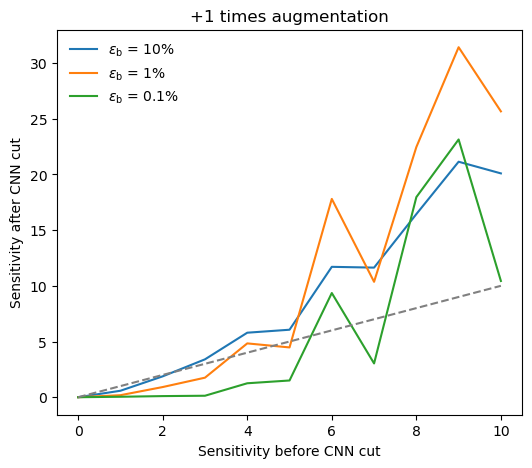

In [5]:
sensitivities = np.arange(11)

sensitivities_01 = []
sensitivities_001 = []
sensitivities_0001 = []

for sensitivity in sensitivities:
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_aug_1/'

    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_01.append(sensitivity * scale_factor)
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.01']
    sensitivities_001.append(sensitivity * scale_factor)
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.001']
    sensitivities_0001.append(sensitivity * scale_factor)

fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(sensitivities, sensitivities_01, label = '$\epsilon_\mathrm{b}$ = 10%')
ax.plot(sensitivities, sensitivities_001, label = '$\epsilon_\mathrm{b}$ = 1%')
ax.plot(sensitivities, sensitivities_0001, label = '$\epsilon_\mathrm{b}$ = 0.1%')
ax.plot(sensitivities, sensitivities, '--', color='grey')

ax.set_title('+1 times augmentation')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')
ax.legend(frameon=False)

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

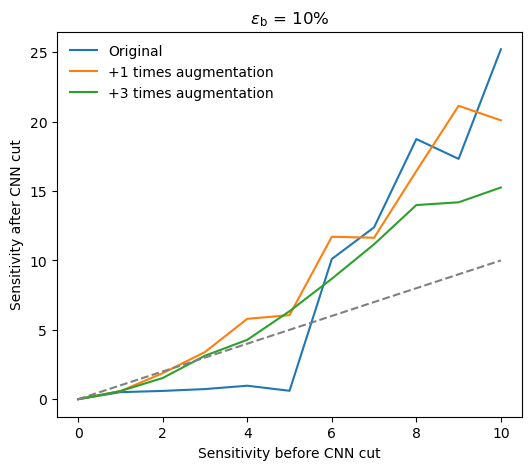

In [6]:
sensitivities = np.arange(11)

sensitivities_aug_0 = []
sensitivities_aug_1 = []
sensitivities_aug_3 = []

for sensitivity in sensitivities:
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_aug_0.append(sensitivity * scale_factor)

    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_aug_1/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_aug_1.append(sensitivity * scale_factor)

    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_aug_3/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_aug_3.append(sensitivity * scale_factor)

fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(sensitivities, sensitivities_aug_0, label='Original')
ax.plot(sensitivities, sensitivities_aug_1, label='+1 times augmentation')
ax.plot(sensitivities, sensitivities_aug_3, label='+3 times augmentation')
ax.plot(sensitivities, sensitivities, '--', color='grey')

ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

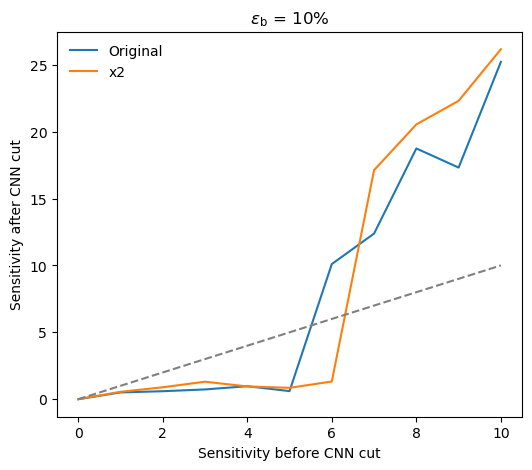

In [7]:
sensitivities = np.arange(11)

sensitivities_aug_0 = []
sensitivities_x2 = []
sensitivities_aug_3 = []

for sensitivity in sensitivities:
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_aug_0.append(sensitivity * scale_factor)

    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_x2/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_x2.append(sensitivity * scale_factor)


fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(sensitivities, sensitivities_aug_0, label='Original')
ax.plot(sensitivities, sensitivities_x2, label='x2')
# ax.plot(sensitivities, sensitivities_aug_3, label='+3 times augmentation')
ax.plot(sensitivities, sensitivities, '--', color='grey')

ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Average selection

In [8]:
file_name = './CWoLa_Hunting_Hidden_Valley_training_results.csv'
df = pd.read_csv(file_name)

In [9]:
sensitivities = np.arange(11)
sensitivities_after, std = [], []

for sensitivity in sensitivities:
    model_name = f'SB_{sensitivity:.1f}_x2'
    scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.1']

    sensitivities_after.append(sensitivity * scale_factor.mean())
    std.append(sensitivity * scale_factor.std())

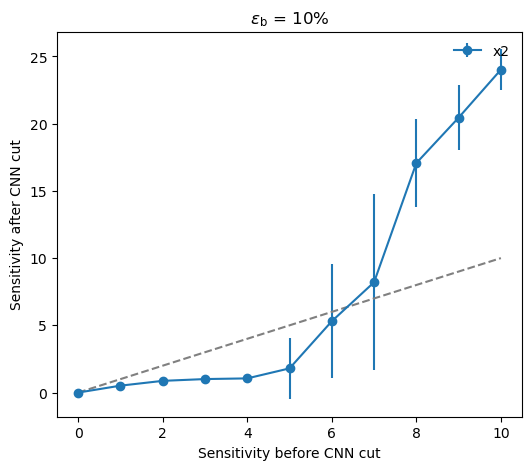

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.errorbar(sensitivities, sensitivities_after, yerr=std, marker='o', label='x2')
ax.plot(sensitivities, sensitivities, '--', color='grey')

ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()